In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from GeoConformalizedExplainer import GeoConformalizedExplainer

C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('../data/us_election.csv')

In [3]:
data.head()

,STATEFP,COUNTYFP,GEOID,ALAND,AWATER,area_name,state_abbr,PST045214,PST040210,PST120214,...,Demvotes12,GOPvotes12,county_fip,state_fips,pct_dem_12,pct_gop_12,diff_2012,pct_pt_12,lon,lat
0,1,5,1005,2291820706,50864677,Barbour County,AL,26887,27457,-2.1,...,5873,5539,5,1,0.512523,0.483376,334,0.029147,-85.393211,31.869580
1,1,23,1023,2365954971,19059247,Choctaw County,AL,13323,13858,-3.9,...,3785,4150,23,1,0.475204,0.521030,365,-0.045825,-88.263180,32.019772
2,1,35,1035,2201896058,6643480,Conecuh County,AL,12670,13228,-4.2,...,3551,3434,35,1,0.506345,0.489662,117,0.016683,-86.993674,31.429234
3,1,51,1051,1601876535,99850740,Elmore County,AL,80977,79296,2.1,...,8940,26223,51,1,0.252257,0.739927,17283,-0.487669,-86.149159,32.596647
4,1,65,1065,1667804583,32525874,Hale County,AL,15184,15760,-3.7,...,5401,3205,65,1,0.625985,0.371465,2196,0.254520,-87.629146,32.762664


In [4]:
dem_pct = data['pct_dem_16']

In [5]:
features = data[['PST045214', 'AGE135214', 'AGE295214', 'AGE775214', 'SEX255214', 'RHI125214',
                 'RHI225214', 'RHI425214', 'RHI525214', 'RHI725214', 'POP645213',
                 'POP815213', 'EDU635213', 'EDU685213', 'VET605213', 'LFE305213', 'INC110213',
                 'PVY020213', 'SBO001207', 'RTN131207']]

In [6]:
loc = data[['lon', 'lat']]

In [7]:
X_train, X_temp, y_train, y_temp, loc_train, loc_temp = train_test_split(features, dem_pct, loc, train_size=0.8, random_state=42)

In [8]:
X_calib, X_test, y_calib, y_test, loc_calib, loc_test = train_test_split(X_temp, y_temp, loc_temp, train_size=0.5, random_state=42)

In [9]:
model = xgb.XGBRegressor(n_estimators=400, max_depth=3, min_child_weight=0.8, colsample_bytree=0.8)

In [10]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=0.8, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [11]:
model.score(X_test, y_test)

0.7898821455768755

In [12]:
feature_names = X_train.columns

In [13]:
explainer = GeoConformalizedExplainer(prediction_f=model.predict,
                                      shap_value_f=None,
                                      x_train=X_train,
                                      x_calib=X_calib,
                                      coord_calib=loc_calib.values,
                                      miscoverage_level=0.1,
                                      band_width=3,
                                      feature_names=feature_names)

In [14]:
results = explainer.uncertainty_aware_explain(x_test=X_test, coord_test=loc_test)

Training SHAP


C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\fastshap\KernelExplainer.py:184: RuntimeWarning: overflow encountered in cast
  ).astype(
C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\fastshap\KernelExplainer.py:184: RuntimeWarning: invalid value encountered in cast
  ).astype(


Calibrating SHAP


C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\fastshap\KernelExplainer.py:184: RuntimeWarning: overflow encountered in cast
  ).astype(


Testing SHAP


C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\fastshap\KernelExplainer.py:184: RuntimeWarning: overflow encountered in cast
  ).astype(


Explaining Variables


ValueError: Shape of passed values is (311, 21), indices imply (311, 20)

In [15]:
results.accuracy_summary()

,coverage_probability,R2,RMSE,SHAP_Var,Pred_SHAP_Var
PST045214,0.877814,0.888533,0.013790,0.001706,0.001913
AGE135214,0.909968,0.614392,0.005074,0.000067,0.000042
AGE295214,0.971061,0.892264,0.013022,0.001574,0.001637
AGE775214,0.919614,0.612639,0.007808,0.000157,0.000083
SEX255214,0.913183,0.654842,0.008520,0.000210,0.000170
RHI125214,0.881029,0.972146,0.011903,0.005086,0.004560
RHI225214,0.877814,0.861744,0.007908,0.000452,0.000334
RHI425214,0.893891,0.615183,0.008825,0.000202,0.000163
RHI525214,0.900322,0.482667,0.003724,0.000027,0.000019
RHI725214,0.922830,0.912962,0.009381,0.001011,0.001080


In [16]:
results.accuracy_summary().to_csv('./USElection_accuracy_summary.csv')

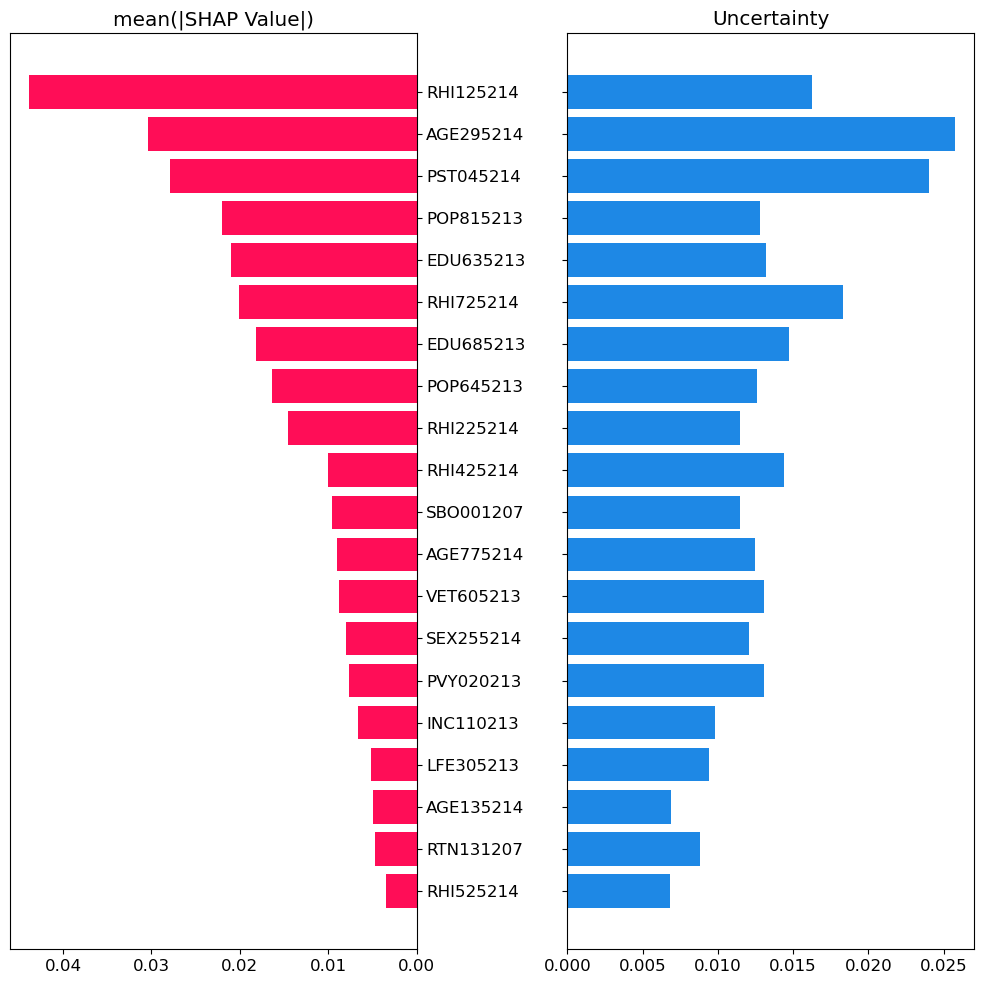

In [17]:
results.plot_absolute_shap_value_with_uncertainty(filename='./USElection_absolute_shap_value_with_uncertainty.pdf')

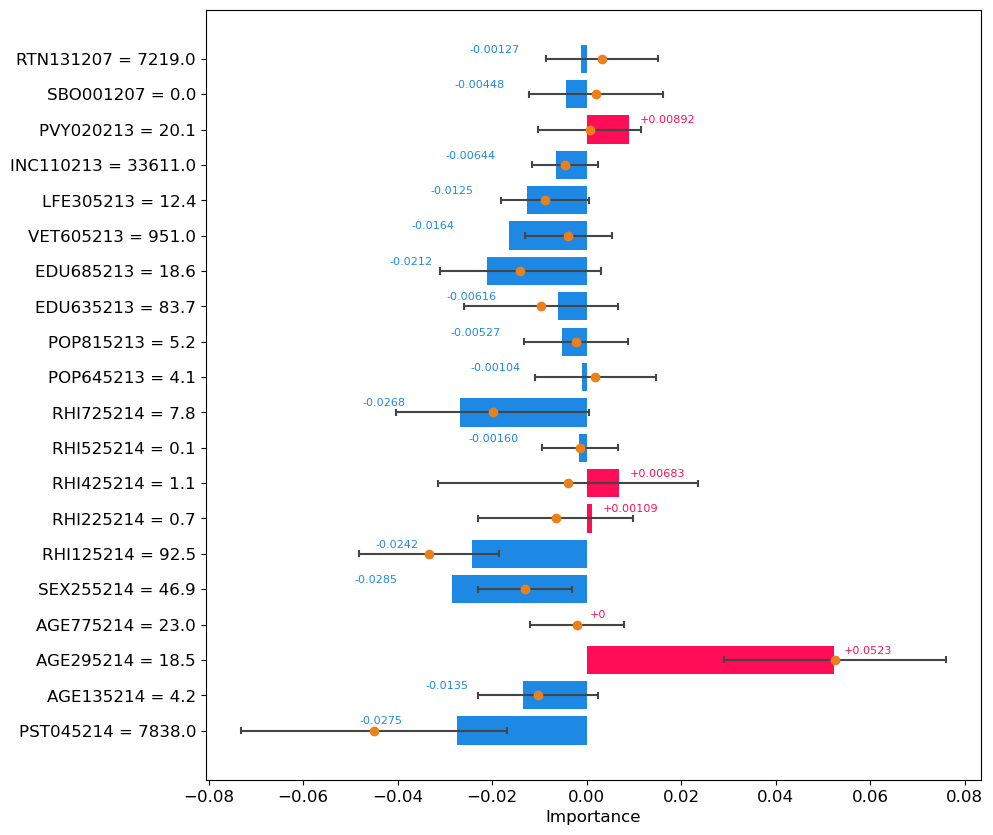

In [18]:
 results.plot_shap_values_with_uncertainty(10, filename='./USElection_shap_values_with_uncertainty.pdf')

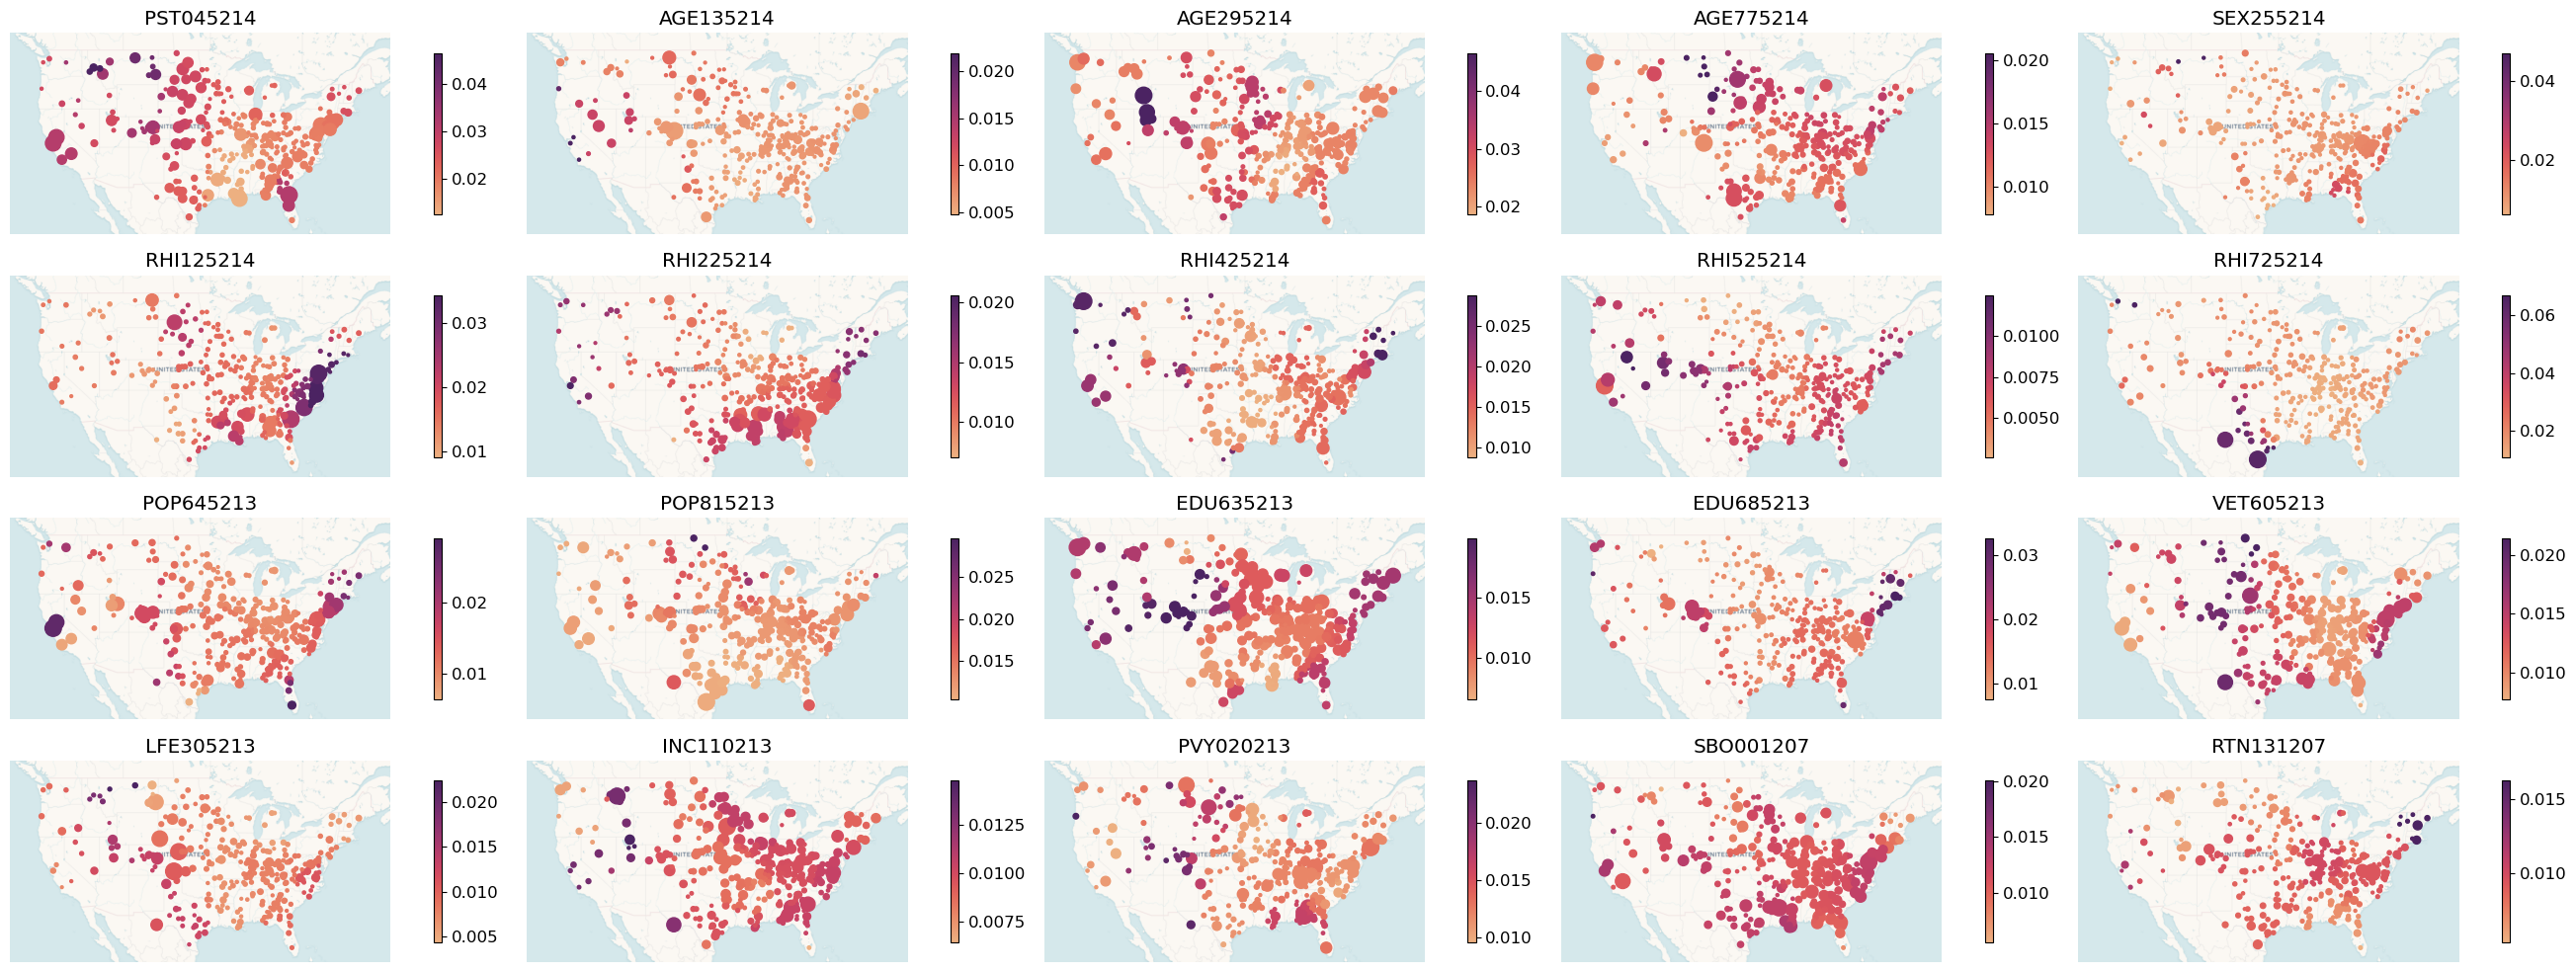

In [19]:
results.plot_geo_uncertainty(figsize=(30, 10), shrink=0.8, filename='USElection_geo_uncertainty.pdf')

100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00

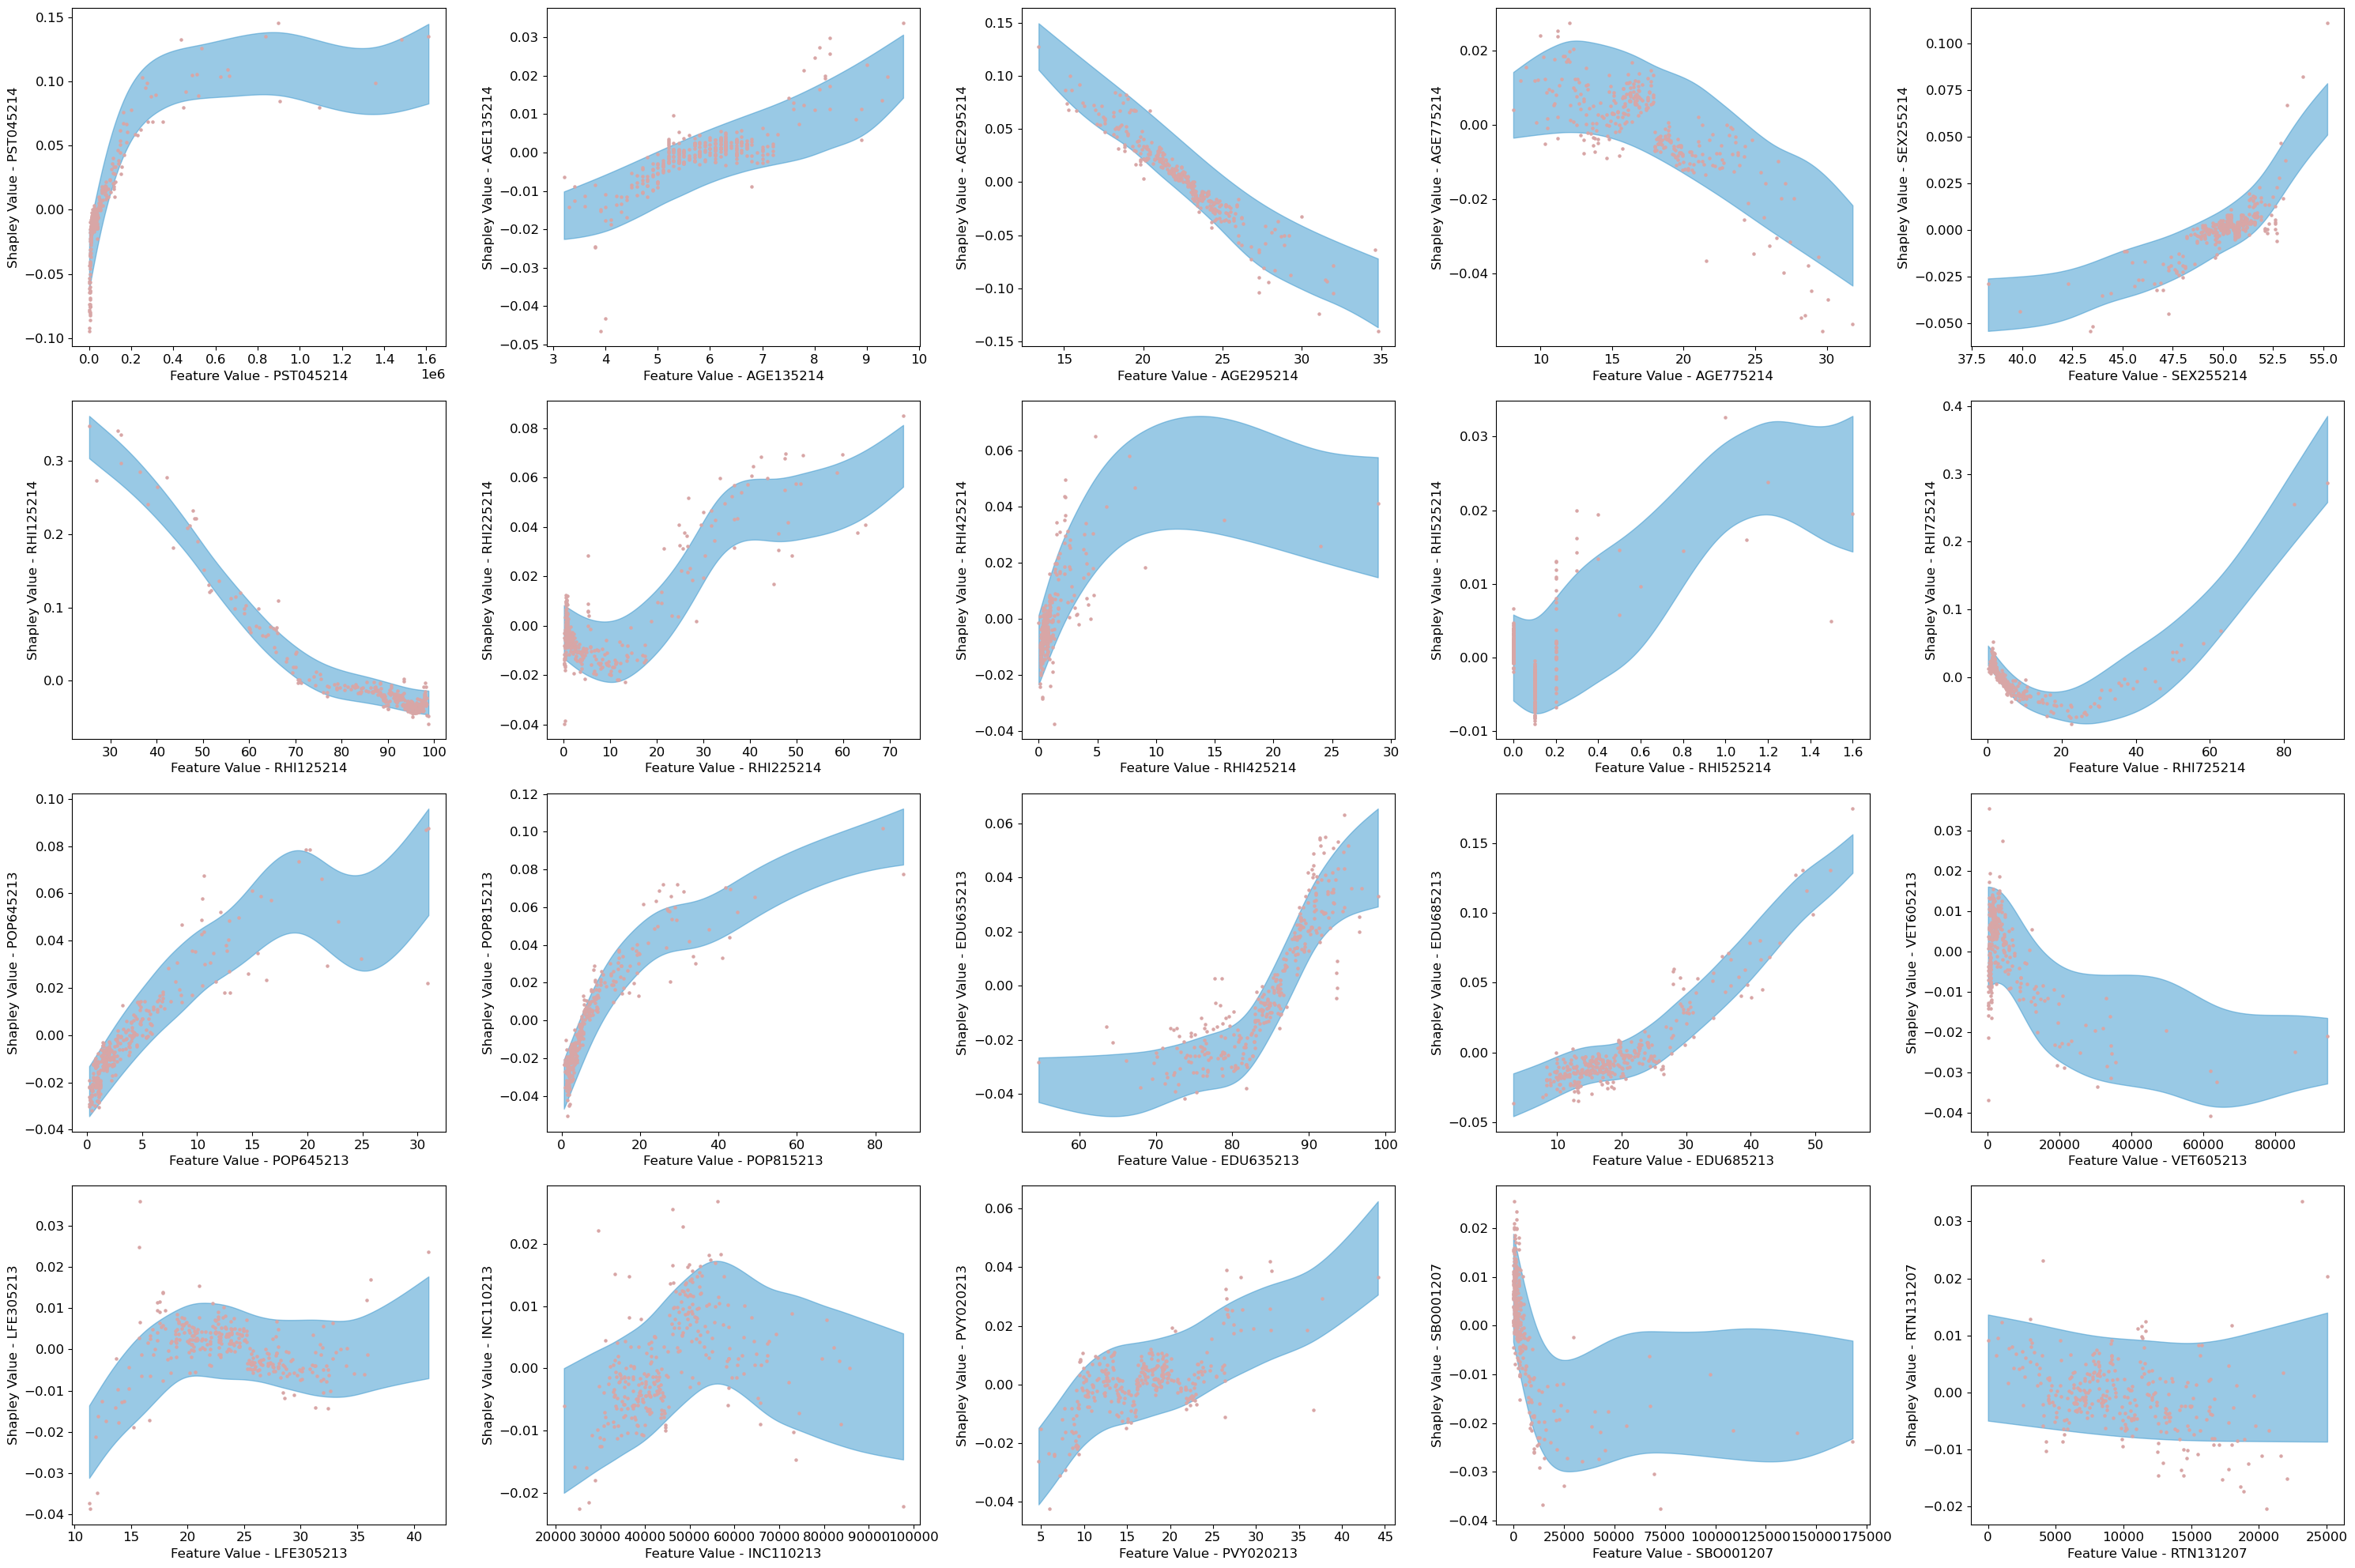

In [20]:
results.plot_partial_dependence_with_fitted_bounds(filename='USElection_partial_dependence_with_fitted_bounds.pdf')